# PART A : Detecting facial keypoints

## 1. First check if the GPU is available and running

In [185]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow Version:", tf.__version__)

# List available devices, filter for GPU devices
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("GPU Available:", gpu)
else:
    print("No GPU found")

TensorFlow Version: 2.10.1
GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 2. Import Libraries

In [147]:
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from google.colab.patches import cv2_imshow

## 3. Load Data and get some information about it.

In [3]:
keyfacial_df = pd.read_csv('./Emotion AI Dataset/data.csv')

In [4]:
keyfacial_df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,67.180378,35.816373,33.239956,34.921932,59.347973,37.000904,72.667896,37.097600,39.404349,36.589944,...,60.065396,64.397610,73.248393,35.446431,74.014748,48.708626,76.760852,48.559612,77.335618,191 191 191 190 189 185 184 120 54 34 19 24 31...
2136,65.724490,36.301020,25.377551,37.311224,58.530612,37.739796,74.448980,37.525510,33.551020,38.107143,...,62.472789,66.928121,79.229046,28.015377,81.151722,48.771976,81.816774,49.287271,82.871156,19 19 19 18 13 7 3 4 3 1 3 9 11 12 12 13 10 9 ...
2137,68.430866,38.651975,28.895857,37.617027,61.659350,40.100902,75.586792,40.219182,37.665118,39.087245,...,63.289576,68.864397,77.495823,22.013981,77.368995,49.180628,79.043130,47.176739,89.544522,31 40 47 31 54 58 63 100 86 80 82 75 79 86 90 ...
2138,64.152180,30.691592,27.000898,40.868082,56.505624,34.126963,73.436776,28.556335,34.746122,40.506939,...,59.735799,73.730743,70.273886,38.777143,80.684286,58.042857,79.301429,58.611086,80.355543,7 1 5 1 3 20 12 0 5 8 6 18 13 9 8 12 12 11 4 8...


In [5]:
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [6]:
# Check if null values exist in the dataframe
keyfacial_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [7]:
keyfacial_df['Image'].shape

(2140,)

In [8]:
keyfacial_df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,...,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,66.221549,36.842274,29.640269,37.063815,59.272128,37.856014,73.412473,37.640110,36.603107,37.920852,...,47.952141,57.253926,63.419076,75.887660,32.967365,76.134065,48.081325,72.681125,48.149654,82.630412
std,2.087683,2.294027,2.051575,2.234334,2.005631,2.034500,2.701639,2.684162,1.822784,2.009505,...,3.276053,4.528635,3.650131,4.438565,3.595103,4.259514,2.723274,5.108675,3.032389,4.813557
min,47.835757,23.832996,18.922611,24.773072,41.779381,27.190098,52.947144,26.250023,24.112624,26.250023,...,24.472590,41.558400,43.869480,57.023258,9.778137,56.690208,32.260312,56.719043,33.047605,57.232296
25%,65.046300,35.468842,28.472224,35.818377,58.113054,36.607950,71.741978,36.102409,35.495730,36.766783,...,46.495330,54.466000,61.341291,72.874263,30.879288,73.280038,46.580004,69.271669,46.492000,79.417480
50%,66.129065,36.913319,29.655440,37.048085,59.327154,37.845220,73.240045,37.624207,36.620735,37.920336,...,47.900511,57.638582,63.199057,75.682465,33.034022,75.941985,47.939031,72.395978,47.980854,82.388899
75%,67.332093,38.286438,30.858673,38.333884,60.521492,39.195431,74.978684,39.308331,37.665280,39.143921,...,49.260657,60.303524,65.302398,78.774969,35.063575,78.884031,49.290000,75.840286,49.551936,85.697976
max,78.013082,46.132421,42.495172,45.980981,69.023030,47.190316,87.032252,49.653825,47.293746,44.887301,...,65.279654,75.992731,84.767123,94.673637,50.973348,93.443176,61.804506,93.916338,62.438095,95.808983


## 4.  Reshape Data

In [9]:
# Since values for the image are given as space separated string, separate the values using ' ' as separator.
# Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96, 96)
keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96, 96))

In [10]:
# Obtain the Shape of the image
keyfacial_df['Image'][0].shape

(96, 96)

## 5. Visualize data

C:\Users\Abdullah\AppData\Local\Temp\ipykernel_18040\2588089196.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')


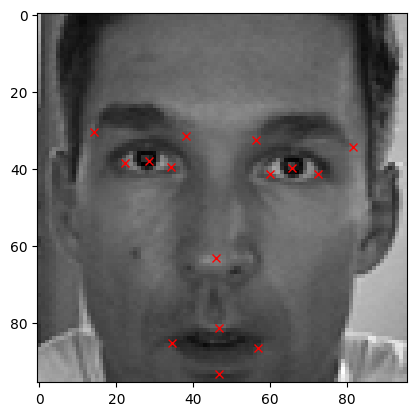

In [11]:
# Get a random image
# Need to put an indicator on each keypoint feature.These are given my keyfacial_df
# x-coordinates are even columns and y coordinates are odd columns.
# we access their value using .loc command, which get the values for coordinates of the image based on the column it is refering to.

i = np.random.randint(1, len(keyfacial_df))
plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

C:\Users\Abdullah\AppData\Local\Temp\ipykernel_18040\2326743768.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')


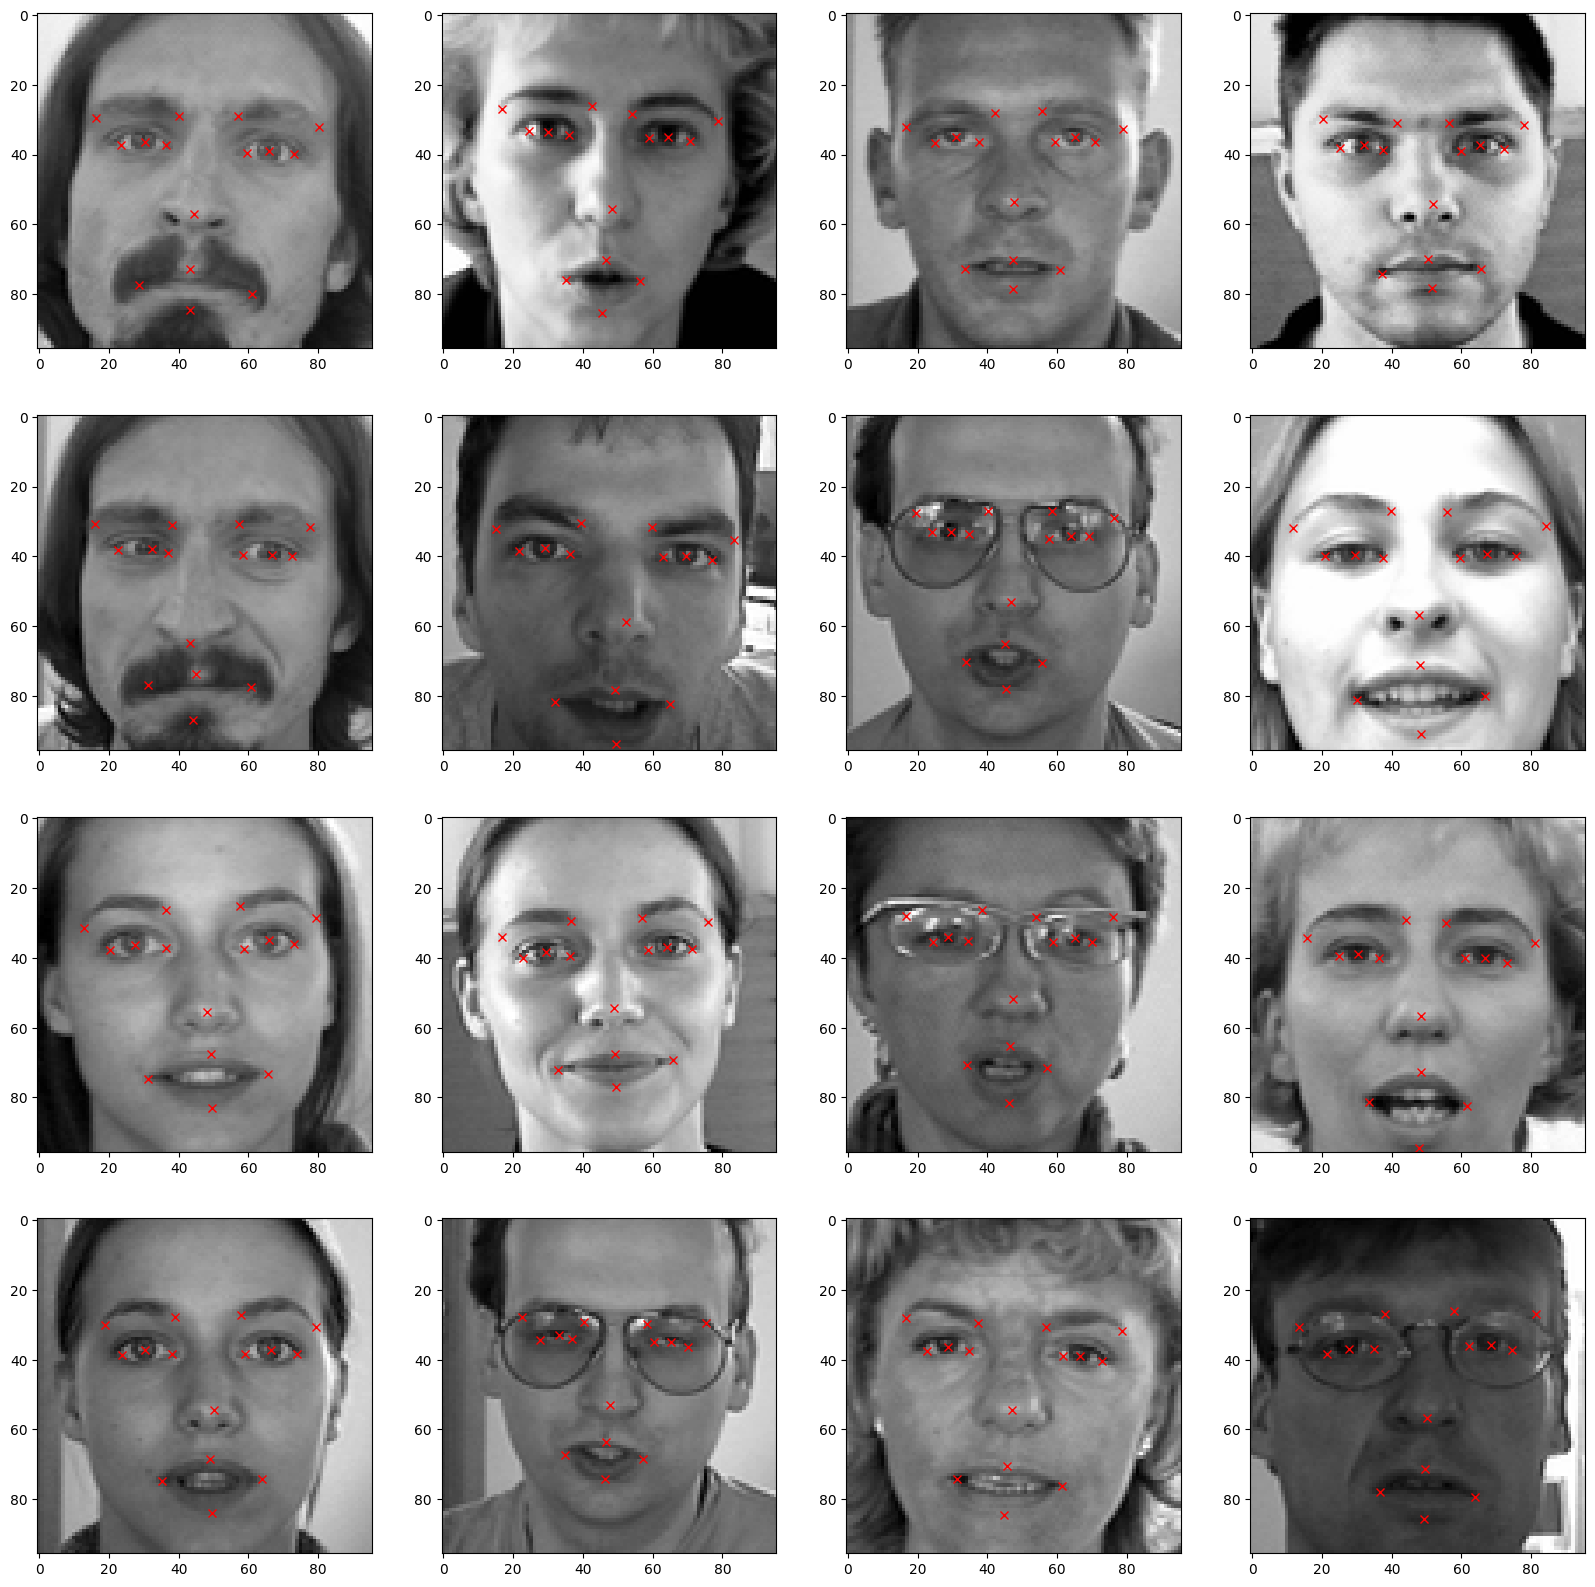

In [12]:
# Let's view more images in a grid format
#Same process but visualises more images..

fig = plt.figure(figsize=(20, 20))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)    
    image = plt.imshow(keyfacial_df['Image'][i],cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

C:\Users\Abdullah\AppData\Local\Temp\ipykernel_18040\3552235260.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx')


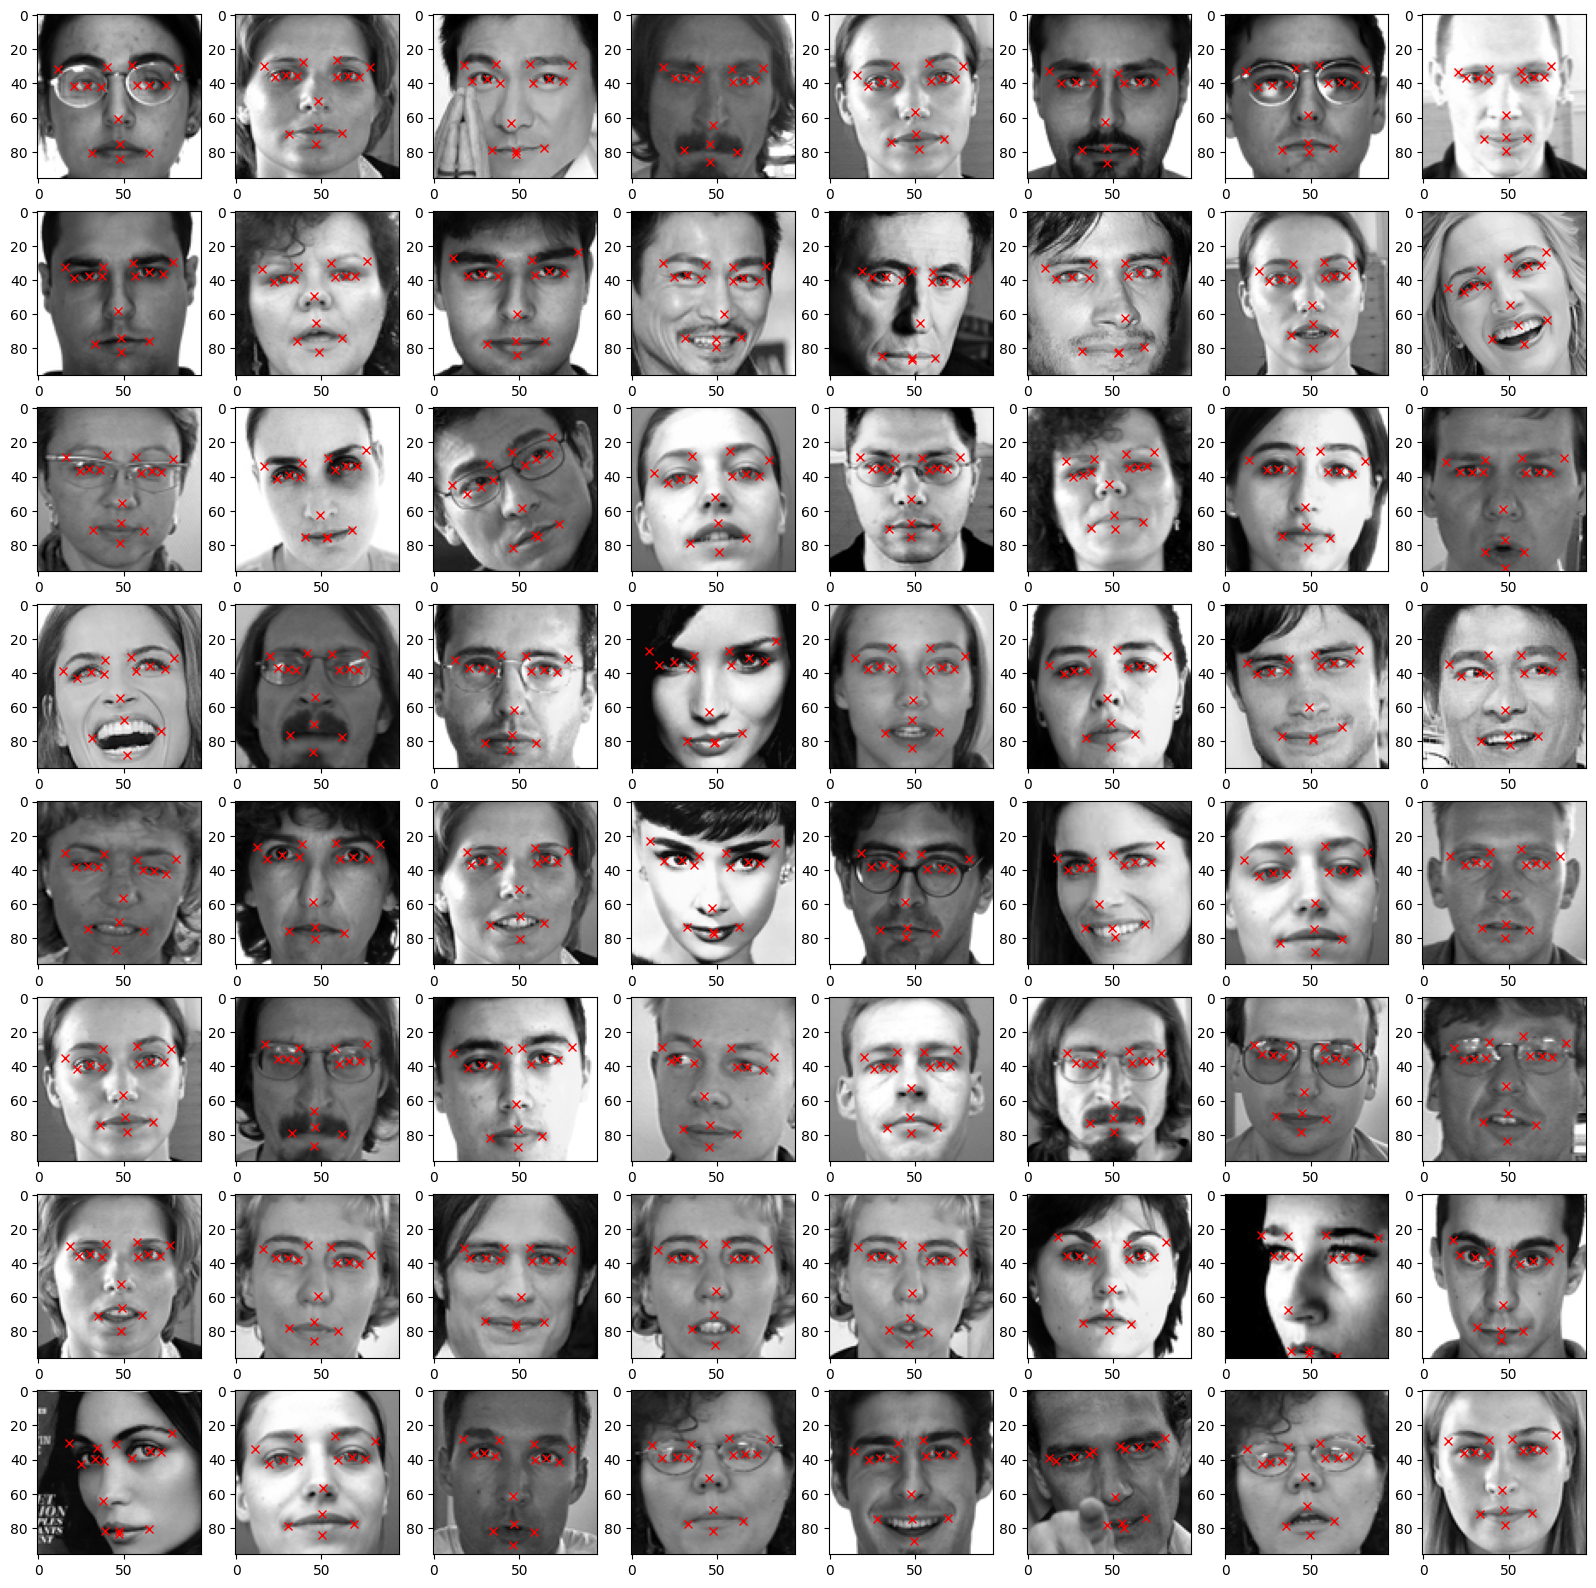

In [13]:
import random

# Let's do a sanity check on random images to ensure the coordinates are accurate. Model is only as good as the data!
fig = plt.figure(figsize=(20, 20))

for i in range(64):
    k = random.randint(1, len(keyfacial_df))
    ax = fig.add_subplot(8, 8, i + 1)    
    image = plt.imshow(keyfacial_df['Image'][k],cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx')

## 6. Perform Image Augmentation

In [14]:
# Create a new copy of the dataframe
import copy
keyfacial_df_copy = copy.copy(keyfacial_df)

In [15]:
# Obtain the columns in the dataframe

columns = keyfacial_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

#### 6.1 Horizontal Flip

In [16]:
# Flip the images along y axis

# Take x values and flip them along y axis.
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

#Now we have to flip the key facial points coordinates as well

# Since we are flipping horizontally, y coordinate values would be the same
# Only x coordiante values would change
# We have to subtract our initial x-coordinate values from width of the image(96)

for i in range(len(columns)):
  if i%2 == 0:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

C:\Users\Abdullah\AppData\Local\Temp\ipykernel_18040\622748720.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')


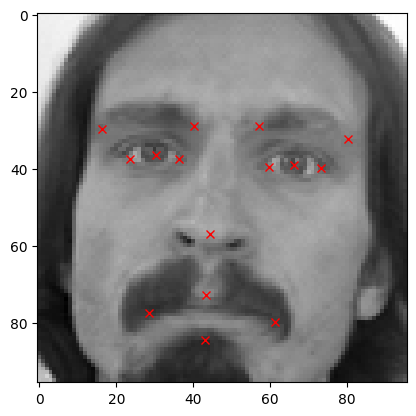

In [17]:
# Show the Original image

plt.imshow(keyfacial_df['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')

C:\Users\Abdullah\AppData\Local\Temp\ipykernel_18040\2825411222.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


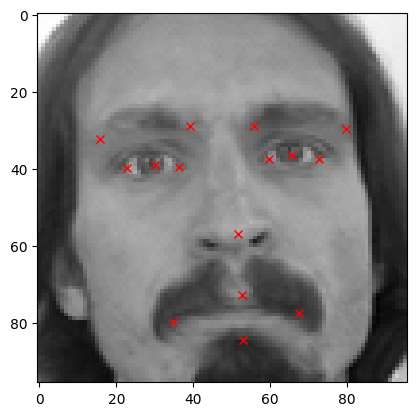

In [18]:
# Show the new augmented Horizontally flipped image

plt.imshow(keyfacial_df_copy['Image'][0],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [19]:
# Concatenate the original dataframe with the augmented dataframe
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy))

In [20]:
# Test the size. It should be double.
augmented_df.shape

(4280, 31)

#### 6.2 Increase brightness

In [21]:
import random

keyfacial_df_copy = copy.copy(keyfacial_df)


# We multiply pixel values by random values between 1.5 and 2 to increase the brightness of the image randomly.
# Since the grey scale images have values between 0 and 255, clip them so it doesn't go beyon.
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x:np.clip(random.uniform(1.5, 2)* x, 0.0, 255.0))

# It should add another 2140
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))
augmented_df.shape

(6420, 31)

C:\Users\Abdullah\AppData\Local\Temp\ipykernel_18040\4183091506.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


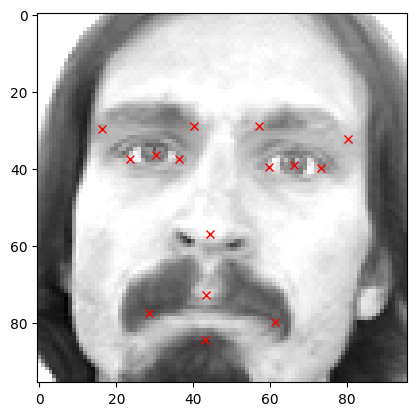

In [22]:
# Show Image with increased brightness

plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

#### 6.3 Vertical Flip

In [23]:
# For the vertical flip, its the same as horizontal flip, but the axis is changed (1 to 0).

keyfacial_df_copy = copy.copy(keyfacial_df)

keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))
for i in range(len(columns)):
  # Since the coloums for the y coordinates are odd, change the remainer of 2 to 1 as well.
  if i%2 == 1:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

C:\Users\Abdullah\AppData\Local\Temp\ipykernel_18040\3675028454.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


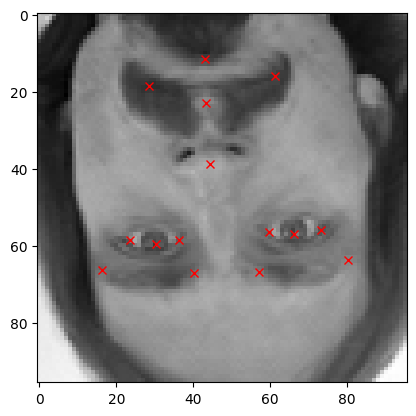

In [24]:
# Perform a sanity check to be sure

plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [25]:
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))

In [26]:
# It should add another 2140
augmented_df.shape

(8560, 31)

## 7. Data normalization

In [27]:
# Obtain the value of images which is present in the 31st column
img = augmented_df[:,30]

# Normalize the images. We can just divide it 255 since it is applicable here.
img = img/255.

# Create an empty array of shape (x, 96, 96, 1) to feed the model
# The model will accept images in batch format so we need to expend it's dimension from (96, 96) to (96, 96, 1)
X = np.empty((len(img), 96, 96, 1))

# Iterate through the img list and add image values to the empty array after it's expansion
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(8560, 96, 96, 1)

In [28]:
# Obtain the value of x & y coordinates which are to used as target. This all columns up until not 30th index (31st column)
y = augmented_df[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(8560, 30)

## 8. Training data preparation 

In [29]:
# Using scikit learn split 80% of data for training and 20% for testing.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [30]:
X_train.shape

(6848, 96, 96, 1)

In [31]:
X_test.shape

(1712, 96, 96, 1)

## 9. Build Deep ResNet Model 

#### 9.1 Res Block : Conv block -> Identity Block 1 -> Identify Block 2 

In [32]:
def res_block(X, filter, stage):

  X_copy = X

  f1 , f2, f3 = filter


  # Applying convolution (2D) | f1 ,(1,1) represents the size of filter f1
  # Strides (l,r) represent how much shifting to left or right in pixels

  
  # Convolutional Block
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)

  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

    
    
    
    
    
    
  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

    
    
    
    
    
  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

#### 9.2 Final Model

In [33]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)

# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)

X = Dense(30, activation = 'relu')(X)

#### 9.3 Model Summary

In [34]:
model_1_facialKeyPoints = tf.keras.Model( inputs= X_input, outputs = X)
model_1_facialKeyPoints.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 48, 48, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1[0][0]']                  
                                                                                              

                                                                                                  
 activation_8 (Activation)      (None, 11, 11, 64)   0           ['bn_2_identity_2_b[0][0]']      
                                                                                                  
 res_2_identity_2_c (Conv2D)    (None, 11, 11, 256)  16640       ['activation_8[0][0]']           
                                                                                                  
 bn_2_identity_2_c (BatchNormal  (None, 11, 11, 256)  1024       ['res_2_identity_2_c[0][0]']     
 ization)                                                                                         
                                                                                                  
 add_2 (Add)                    (None, 11, 11, 256)  0           ['bn_2_identity_2_c[0][0]',      
                                                                  'activation_6[0][0]']           
          

                                                                                                  
 res_3_identity_2_c (Conv2D)    (None, 5, 5, 512)    66048       ['activation_17[0][0]']          
                                                                                                  
 bn_3_identity_2_c (BatchNormal  (None, 5, 5, 512)   2048        ['res_3_identity_2_c[0][0]']     
 ization)                                                                                         
                                                                                                  
 add_5 (Add)                    (None, 5, 5, 512)    0           ['bn_3_identity_2_c[0][0]',      
                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 5, 5, 512)    0           ['add_5[0][0]']                  
          

## 10. Compile And Train the Model 

#### 10.1 Compile the model

In [132]:
# Refer to Adam optimizer: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9377, beta_2 = 0.999, amsgrad = False)
model_1_facialKeyPoints.compile(loss = "mean_squared_error", optimizer = adam , metrics = ['accuracy'])

#### 10.2 Save the best model

In [133]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "./Emotion AI Dataset/save/FacialKeyPoints_weights.hdf5", verbose = 1, save_best_only = True)

#### 10.3 Train the model

In [134]:
history = model_1_facialKeyPoints.fit(X_train, y_train, batch_size = 1024, epochs = 20, validation_split = 0.3, callbacks=[checkpointer])

Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 5.6286 - accuracy: 0.8859
Epoch 1: val_loss improved from inf to 10.59210, saving model to ./Emotion AI Dataset/save\FacialKeyPoints_weights.hdf5
5/5 [==============================] - 2s 249ms/step - loss: 5.6286 - accuracy: 0.8859 - val_loss: 10.5921 - val_accuracy: 0.8603
Epoch 2/20
5/5 [==============================] - ETA: 0s - loss: 4.3470 - accuracy: 0.8886
Epoch 2: val_loss improved from 10.59210 to 9.14264, saving model to ./Emotion AI Dataset/save\FacialKeyPoints_weights.hdf5
5/5 [==============================] - 1s 198ms/step - loss: 4.3470 - accuracy: 0.8886 - val_loss: 9.1426 - val_accuracy: 0.8637
Epoch 3/20
5/5 [==============================] - ETA: 0s - loss: 3.5931 - accuracy: 0.8867
Epoch 3: val_loss did not improve from 9.14264
5/5 [==============================] - 1s 132ms/step - loss: 3.5931 - accuracy: 0.8867 - val_loss: 9.3585 - val_accuracy: 0.8457
Epoch 4/20
5/5 [=============================

#### 10.4 Save the actual architecture of the model

In [135]:
model_json = model_1_facialKeyPoints.to_json()
with open("./Emotion AI Dataset/save/FacialKeyPoints-model.json","w") as json_file:
  json_file.write(model_json)

## 11. Test the model performance

#### 11.1 Load the model architecture

In [136]:
with open('./Emotion AI Dataset/save/FacialKeyPoints-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
model_1_facialKeyPoints = tf.keras.models.model_from_json(json_savedModel)
model_1_facialKeyPoints.load_weights('./Emotion AI Dataset/save/FacialKeyPoints_weights.hdf5')
model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer= adam , metrics = ['accuracy'])

#### 11.2 Evaluate the model Accuracy

In [137]:
result = model_1_facialKeyPoints.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

54/54 [==============================] - 0s 3ms/step - loss: 4.0500 - accuracy: 0.8832
Accuracy : 0.8831775784492493


In [138]:
# Get the model keys 
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

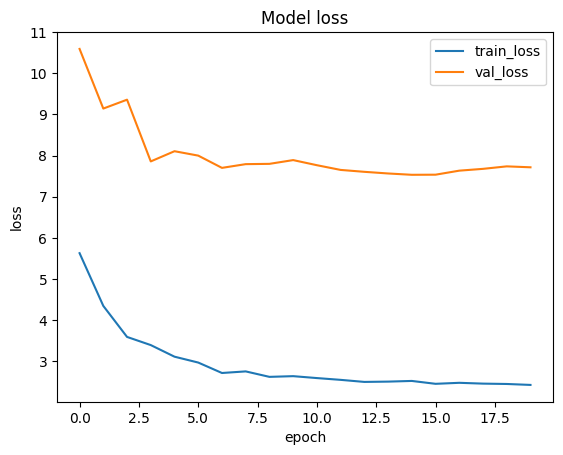

In [139]:
# Plot the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

# PART B: Facial Expression Detection

## 1. Load data and get some info about it

In [140]:
# read the csv files for the facial expression data
facialexpression_df = pd.read_csv('./Emotion AI Dataset/icml_face_data.csv')

In [141]:
facialexpression_df

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
...,...,...
24563,3,0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
24564,0,181 177 176 156 178 144 136 132 122 107 131 16...
24565,3,178 174 172 173 181 188 191 194 196 199 200 20...
24566,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...


In [142]:
facialexpression_df[' pixels'][0] # It is a String format

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

## 2. Reshape Data

In [143]:
# Convert pixel values in string format to array format

def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [144]:
# Resize images from (48, 48) to (96, 96) like in part A using opensv with Inter_cubic interpolation

def resize(x):
  
  img = x.reshape(48, 48)
  return cv2.resize(img, dsize=(96, 96), interpolation = cv2.INTER_CUBIC)

In [145]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: string2array(x))

In [148]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: resize(x))

In [149]:
# Visualize
facialexpression_df.head()

,emotion,pixels
0,0,"[[69.316925, 73.03865, 79.13719, 84.17186, 85...."
1,0,"[[151.09435, 150.91393, 150.65791, 148.96367, ..."
2,2,"[[23.061905, 25.50914, 29.47847, 33.99843, 36...."
3,2,"[[20.083221, 19.079437, 17.398712, 17.158691, ..."
4,3,"[[76.26172, 76.54747, 77.001785, 77.7672, 78.4..."


#### 2.1 Check shape and null values of the data frame

In [150]:
# check the shape of data_frame
facialexpression_df.shape

(24568, 2)

In [151]:
# check for the presence of null values in the data frame
# Since it is 0, no need to clean the data
facialexpression_df.isnull().sum()

emotion    0
 pixels    0
dtype: int64

#### 2.2 Categorize relations with emotion number

In [152]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}

## 3. Visualize the image

#### 3.1 Vizualize the first image to see if it makes sense after all the transformations we made to out dataframe

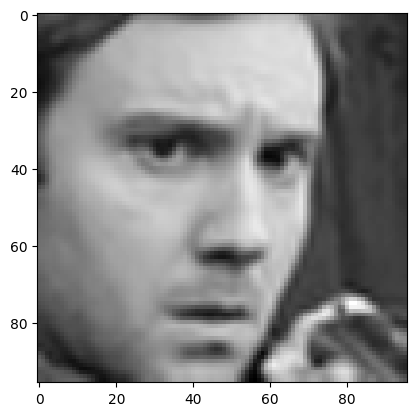

In [154]:
plt.imshow(facialexpression_df[' pixels'][0], cmap = 'gray')
# The resolution seems low because we just amplified the pixel count by 4 times (48 x 48 to 96 x 96). So it is normal.

#### 3.2 Sanity Check: Plot 1 image for each emotion

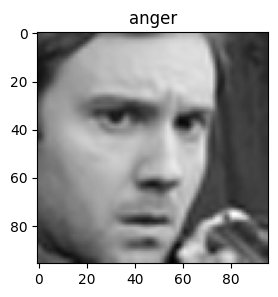

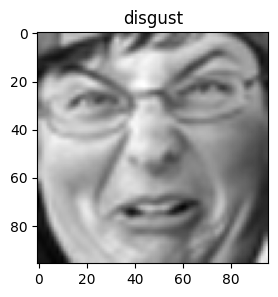

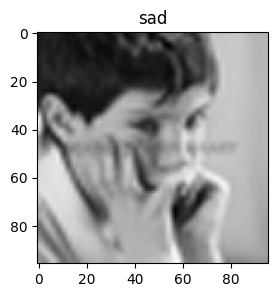

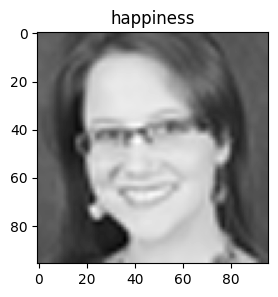

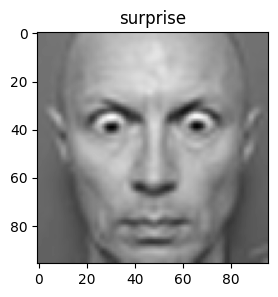

In [159]:
emotions = [0, 1, 2, 3, 4]

for i in emotions:
  # Add title for easiness
  data = facialexpression_df[facialexpression_df['emotion'] == i][:1]
  img = data[' pixels'].item()
  img = img.reshape(96, 96)
  plt.figure(figsize=(4, 3))
  plt.title(label_to_text[i])
  plt.imshow(img, cmap = 'gray')

#### 3.3 Determine number of images per emotion

In [161]:
facialexpression_df.emotion.value_counts().index

Index([3, 2, 0, 4, 1], dtype='int64', name='emotion')

In [162]:
facialexpression_df.emotion.value_counts()

emotion
3    8989
2    6077
0    4953
4    4002
1     547
Name: count, dtype: int64

<Axes: xlabel='emotion', ylabel='count'>

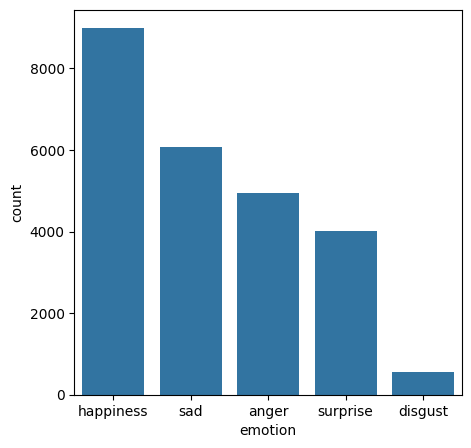

In [165]:
plt.figure(figsize = (5,5))
sns.barplot(x = facialexpression_df.emotion.value_counts().index.map(label_to_text), y = facialexpression_df.emotion.value_counts())

# Have to perform data augmentation for disgust.

## 4. Data preparation

#### 4.1 Split the dataframe in to features and labels

In [166]:
from keras.utils import to_categorical

X = facialexpression_df[' pixels']
y = to_categorical(facialexpression_df['emotion'])

In [169]:
X

0        [[69.316925, 73.03865, 79.13719, 84.17186, 85....
1        [[151.09435, 150.91393, 150.65791, 148.96367, ...
2        [[23.061905, 25.50914, 29.47847, 33.99843, 36....
3        [[20.083221, 19.079437, 17.398712, 17.158691, ...
4        [[76.26172, 76.54747, 77.001785, 77.7672, 78.4...
                               ...                        
24563    [[-4.901001, 5.6496277, 22.477203, 49.366516, ...
24564    [[181.71645, 179.72063, 176.40785, 175.93037, ...
24565    [[178.1166, 176.83118, 174.74146, 172.61276, 1...
24566    [[16.883408, 16.953583, 17.081573, 16.53476, 1...
24567    [[30.199814, 29.574478, 28.545822, 27.846603, ...
Name:  pixels, Length: 24568, dtype: object

In [170]:
X[0] # As we can see, it needs to be organized

array([[ 69.316925,  73.03865 ,  79.13719 , ...,  40.73619 ,  40.6584  ,
         40.5394  ],
       [ 68.66325 ,  70.95224 ,  74.71768 , ...,  43.274765,  42.037186,
         41.223618],
       [ 67.768814,  67.71646 ,  67.67172 , ...,  47.39473 ,  44.26329 ,
         42.31465 ],
       ...,
       [ 74.89021 ,  76.79553 ,  79.90259 , ...,  71.463425,  59.32875 ,
         51.74736 ],
       [ 76.68126 ,  75.808105,  74.25452 , ...,  93.943375,  79.77934 ,
         71.13246 ],
       [ 77.63858 ,  75.15074 ,  70.8846  , ..., 107.66351 ,  92.23212 ,
         82.91585 ]], dtype=float32)

In [171]:
y 

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [172]:
# Since we need to convert the shape

X = np.stack(X, axis = 0)
X = X.reshape(24568, 96, 96, 1)

print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


#### 4.2 Data splitting in to train, test and validation data frames

In [173]:
from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test, y_Test, test_size = 0.5, shuffle = True)


In [174]:
print(X_val.shape, y_val.shape)

(1228, 96, 96, 1) (1228, 5)


In [175]:
print(X_Test.shape, y_Test.shape)

(1229, 96, 96, 1) (1229, 5)


In [176]:
print(X_train.shape, y_train.shape)

(22111, 96, 96, 1) (22111, 5)


## 5. Data normalization

In [177]:
# We can just simply normalize by dividing it by 255 since it only it is greyscale color. No need for libraries.

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

## 6. Data Augmentation

In [179]:
# Using Keras library this time : https://keras.io/api/data_loading/image/

train_datagen = ImageDataGenerator(
rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = [1.1, 1.5], # Numbers larger than 1.0 brighten the image [1.0, 1.5] 
    fill_mode = "nearest")

## 7. Build Deep ResNet Model

#### 7.1 Final model (Uses res block defined in part A)

In [182]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# 4 - stage
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
# Must use softmax (ranges between -1 and 1) and it should have 5 nodes since 5 emotions
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

#### 7.2 Model summary

In [183]:
model_2_emotion = tf.keras.Model( inputs= X_input, outputs = X, name = 'Resnet18')
model_2_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 102, 102, 1)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 48, 48, 64)   3200        ['zero_padding2d_2[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1[0][0]']           

 res_2_identity_2_b (Conv2D)    (None, 11, 11, 64)   36928       ['activation_45[0][0]']          
                                                                                                  
 bn_2_identity_2_b (BatchNormal  (None, 11, 11, 64)  256         ['res_2_identity_2_b[0][0]']     
 ization)                                                                                         
                                                                                                  
 activation_46 (Activation)     (None, 11, 11, 64)   0           ['bn_2_identity_2_b[0][0]']      
                                                                                                  
 res_2_identity_2_c (Conv2D)    (None, 11, 11, 256)  16640       ['activation_46[0][0]']          
                                                                                                  
 bn_2_identity_2_c (BatchNormal  (None, 11, 11, 256)  1024       ['res_2_identity_2_c[0][0]']     
 ization) 

 res_3_identity_2_b (Conv2D)    (None, 5, 5, 128)    147584      ['activation_54[0][0]']          
                                                                                                  
 bn_3_identity_2_b (BatchNormal  (None, 5, 5, 128)   512         ['res_3_identity_2_b[0][0]']     
 ization)                                                                                         
                                                                                                  
 activation_55 (Activation)     (None, 5, 5, 128)    0           ['bn_3_identity_2_b[0][0]']      
                                                                                                  
 res_3_identity_2_c (Conv2D)    (None, 5, 5, 512)    66048       ['activation_55[0][0]']          
                                                                                                  
 bn_3_identity_2_c (BatchNormal  (None, 5, 5, 512)   2048        ['res_3_identity_2_c[0][0]']     
 ization) 

## 8. Compile And Train the Model 


#### 8.1 Compile model

In [308]:
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

#### 8.2 Save the best model

In [309]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "./Emotion AI Dataset/save/FacialExpression_weights.hdf5", verbose = 1, save_best_only=True)

#### 8.3 Train model

In [310]:
history = model_2_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=1024),
  validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 1024,
  epochs= 50, callbacks=[checkpointer, earlystopping])

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 0.2980 - accuracy: 0.8885
Epoch 1: val_loss improved from inf to 0.29326, saving model to ./Emotion AI Dataset/save\FacialExpression_weights.hdf5
21/21 [==============================] - 8s 330ms/step - loss: 0.2980 - accuracy: 0.8885 - val_loss: 0.2933 - val_accuracy: 0.8844
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.2805 - accuracy: 0.8935
Epoch 2: val_loss did not improve from 0.29326
21/21 [==============================] - 7s 307ms/step - loss: 0.2805 - accuracy: 0.8935 - val_loss: 0.3133 - val_accuracy: 0.8803
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.2688 - accuracy: 0.8991
Epoch 3: val_loss did not improve from 0.29326
21/21 [==============================] - 6s 304ms/step - loss: 0.2688 - accuracy: 0.8991 - val_loss: 0.3570 - val_accuracy: 0.8656
Epoch 4/50
21/21 [==============================] - ETA: 0s - loss: 0.2616 - accuracy: 0.9040
Epoch 4: val_loss

#### 8.4 Save the actual architecture of the model

In [311]:
# saving the model architecture to json file for future use

model_json = model_2_emotion.to_json()
with open("./Emotion AI Dataset/save/FacialExpression-model.json","w") as json_file:
  json_file.write(model_json)

## 9. Test the model performance

#### 9.1 Load the model architecture

In [312]:
with open('./Emotion AI Dataset/save/FacialExpression-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_2_emotion = tf.keras.models.model_from_json(json_savedModel)
model_2_emotion.load_weights('./Emotion AI Dataset/save/FacialExpression_weights.hdf5')
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

#### 9.2 Evaluate the model Accuracy

In [313]:
score = model_2_emotion.evaluate(X_Test, y_Test)
print('Test Accuracy: {}'.format(score[1]))

39/39 [==============================] - 0s 3ms/step - loss: 0.2701 - accuracy: 0.9015
Test Accuracy: 0.9015460014343262


In [314]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [315]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

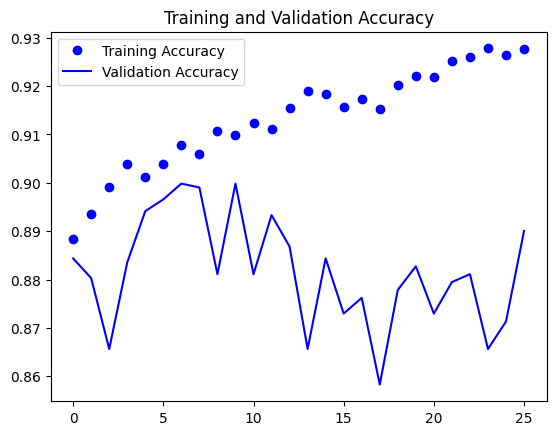

In [316]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

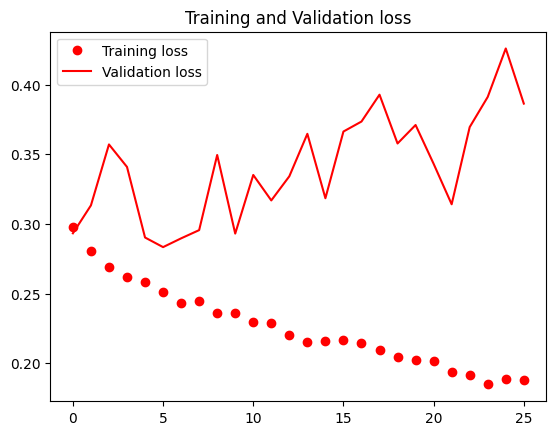

In [317]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()